# Hierarchical clustering program using different distance measures

Use pm4py for importing different event logs found in logs folder

In [1]:
import pandas as pd
import pm4py
import networkx as nx
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import pprint

def get_log(path):
    '''
    Reads in an event log from the logs folder using pm4py 
    '''

    return pm4py.read_xes(path)

def get_filtered_log(path):
    filtered_log = get_log(path)
    filtered_log = pm4py.filter_variants_top_k(filtered_log, 11)

    return filtered_log

# fetch the information out of an event log using pm4py
#log = get_log("../logs/sepsis_event_log.xes")
log = get_filtered_log("../logs/sepsis_event_log.xes")

/home/jamie/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

/home/jamie/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/jamie/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/jamie/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/jamie/.local/lib/py

Different helper methods

In [6]:
def print_log_info(log, verbose=False):
    '''
    Prints out useful information of the given event log

    Prints out all start activities, end activities, all event attributes, and all trace attributes.
    If verbose is True, then all values of all event and trace attributes are printed out plus all variants of the event log
    '''

    start_activities = pm4py.stats.get_start_activities(log)
    end_activities = pm4py.stats.get_end_activities(log)
    event_attributes = pm4py.stats.get_event_attributes(log)
    trace_attributes = pm4py.stats.get_trace_attributes(log)
    
    info = f"Event log information:\n"
    info += f"Start activities: {start_activities}\n"
    info += f"End activities: {end_activities}\n"
    info += f"Event attributes: {event_attributes}\n"
    info += f"Trace attributes: {trace_attributes}\n"

    # add additional info if wished for
    if verbose:
        event_attribute_values = [
            {attribute: pm4py.stats.get_event_attribute_values(log, attribute)}
            for attribute in event_attributes
        ]
        trace_attribute_values = [
            {attribute: pm4py.stats.get_trace_attribute_values(log, attribute)}
            for attribute in trace_attributes
        ]
        variants = pm4py.stats.get_variants(log)

        info += f"Event attribute values: {event_attribute_values}\n"
        info += f"Trace attribute values: {trace_attribute_values}\n"
        info += f"Variants: {variants}"

    print(info)

def show_dfg_of_log(log):
    '''
    Displays the directly follows graph of an event log
    '''

    dfg, start_activities, end_activities = pm4py.discovery.discover_dfg(log, 
                                                                         case_id_key= "case:concept:name",
                                                                         activity_key= "concept:name")

    return pm4py.vis.view_dfg(dfg, start_activities, end_activities, format="png")

def get_jaccard_distance_of_dfg(log):
    '''
    Computes the jaccard measure of two nodes using the DFG

    NetworkX provides an implementation of the jaccard measure in directly-follows-graphs.
    First the DFG has to be generated using pm4py. The output gets formatted for a NetworkX graph.
    Output is an iterator of the pairwise distances of the nodes in the graph
    '''

    # convert event log to an undirected NetworkX graph
    dfg, start, end = pm4py.discover_dfg(log)
    edge_list = [(edge[0], edge[1], weight) for edge, weight in dfg.items()]
    dg = nx.DiGraph()
    dg.add_weighted_edges_from(edge_list)

    # compute the jaccard measures of the nodes
    distances = nx.jaccard_coefficient(dg.to_undirected())

    # print distances between the nodes
    #   for distance in distances:
    #        print(distance)

    return distances

def get_simrank_similarity_of_dfg(log):
    '''
    Computes the simrank similarity of two nodes using the DFG

    Output is a dictionary of dictionaries with the first key being the source node, the key
    in the second dictionary being the target node, and the value being the simrank similarity.
    The distance relation between source and target are symmetrical. 
    '''

    # convert event log to a NetworkX graph
    dfg, start, end = pm4py.discover_dfg(log)
    edge_list = [(edge[0], edge[1], weight) for edge, weight in dfg.items()]
    dg = nx.DiGraph()
    dg.add_weighted_edges_from(edge_list)

    # compute the simrank similarity of the nodes
    distances = nx.simrank_similarity(dg)

    # print distances between the nodes
    #   pprint.pprint(distances)

    return distances

def convert_jaccard_distances_to_distance_matrix(log, pairwise_distances):
    '''
    Converts the pairwise distances iterator from NetworkX to a distance matrix

    First finds the attributes and generates an empty distance matrix.
    The cells will be filled with 1 - the values of the corresponding jaccard measure.
    Remaining cells have the distance 1
    Returns the list of activities and the distance matrix
    '''
    
    # retrieve all attribute values
    activities = list(pm4py.get_event_attribute_values(log, "concept:name").keys())
    activities.sort()

    # create empty distance matrix using the activity names    
    distance_matrix = pd.DataFrame(columns=activities, index=activities)

    # fill matrix up
    for u, v, distance in pairwise_distances:
        distance_matrix[u][v] = 1 - round(distance, 3)
        distance_matrix[v][u] = 1 - round(distance, 3)

    distance_matrix = distance_matrix.fillna(1) # no similarity -> distance = 1
    distance_matrix = distance_matrix.to_numpy()
    np.fill_diagonal(distance_matrix, 0) # similarity to itself is always 0
    
    # return only the values of the matrix, not the names of the activities
    return activities, distance_matrix

def convert_simrank_distances_to_distance_matrix(log, pairwise_distances):
    '''
    Converts the pairwise distances dictionary of dictionaries to a distance matrix
    '''

    # create distance matrix using the pairwise distances dictionary and sort them
    distance_matrix = pd.DataFrame(pairwise_distances)
    distance_matrix = distance_matrix.reindex(sorted(distance_matrix.columns), axis="index")
    distance_matrix = distance_matrix.reindex(sorted(distance_matrix.columns), axis="columns")
    activities = distance_matrix.columns

    # transform values and convert to numpy matrix
    distance_matrix = distance_matrix.transform(lambda x: round(1 - x, 3))
    print(distance_matrix)
    distance_matrix = distance_matrix.to_numpy()
    
    # return only the values of the matrix, not the names of the activities
    return activities, distance_matrix

def create_linkage(distances):
    '''
    Performs hierarchical clustering using average linkage with scipy
    Returns the linkage matrix
    '''

    # input for the method has to be a condensed distance matrix
    condensed_matrix = squareform(distances)

    # perform hierarchical clustering
    return linkage(condensed_matrix, 'average')

def create_dendrogram(activities, linkage_matrix):
    '''
    Creates the dendrogram of the hierarchical clustering operation using scipy
    Displays the dendrogram to the terminal
    '''
    
    # create dendrogram out of data
    dn = dendrogram(linkage_matrix,
                    orientation="right",
                    labels=activities)

    return dn

def create_clusterings_for_every_level(activities, distances, linkage_matrix):
    '''
    Creates a dictionary for every clustering. Each entry includes a list of clusterings 
    for every level of the dendrogram.
    Returns the clustering dictionary
    '''

    # output dictionary and the number of done merges 
    clusterings = {}
    num_merges = 0

    # add a singleton cluster for every activity at first entry in clusterings dictionary
    dct = dict([(i, {activities[i]}) for i in range(distances.shape[0])])
    clusterings[0] = list(dct.values())

    # adapted from: https://stackoverflow.com/a/65060545
    for i, row in enumerate(linkage_matrix, distances.shape[0]):
        # add for every merge a union of the merged clusters and delete the old ones
        dct[i] = dct[row[0]].union(dct[row[1]])
        del dct[row[0]]
        del dct[row[1]]
        num_merges += 1

        # save the clustering in the output dictionary
        clusterings[num_merges] = list(dct.values())
    
    return clusterings

def create_hierarchy_for_activities(activities, clusterings):
    '''
    Returns every cluster each activity was ever in. This in return generates the hierarchy needed
    for abstraction of event logs
    Hint: Currect runtime is O(|activities|^2), there maybe is a faster method, though this is fine for now
    '''

    # create empty hierarchy lists for each activity
    hierarchies = {activity: [] for activity in activities}

    # for each cluster in each level add the new cluster to the corresponding activities
    for level in clusterings.values():
        for cluster in level:
            for activity in cluster:
                act_hierarchy = hierarchies[activity]
                # skip cluster if it is already in its hierarchy
                if cluster in act_hierarchy:
                    continue
                act_hierarchy.append(cluster)

    return hierarchies


Main program for executing the generalisation hierarchies

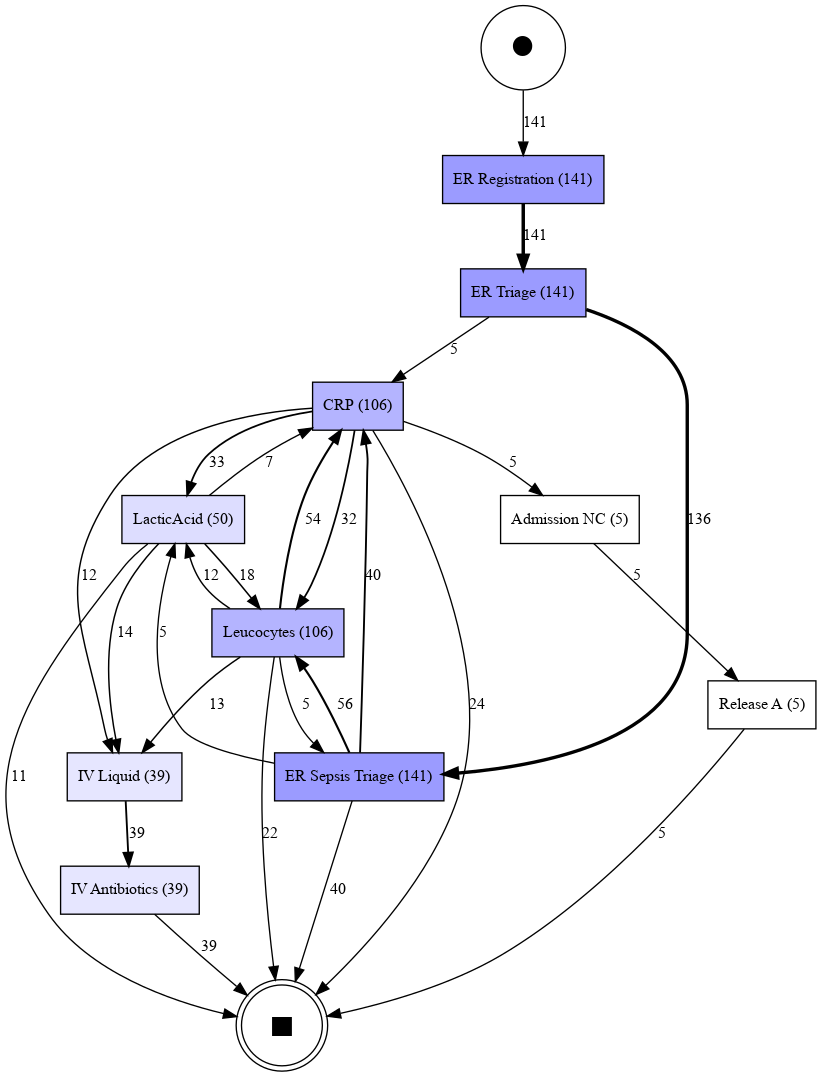

                  Admission NC    CRP  ER Registration  ER Sepsis Triage   
Admission NC             0.000  0.845              1.0             0.992  \
CRP                      0.845  0.000              1.0             0.942   
ER Registration          1.000  1.000              0.0             1.000   
ER Sepsis Triage         0.992  0.942              1.0             0.000   
ER Triage                1.000  1.000              1.0             1.000   
IV Antibiotics           0.749  0.867              1.0             0.993   
IV Liquid                0.563  0.721              1.0             0.983   
LacticAcid               0.344  0.749              1.0             0.987   
Leucocytes               0.662  0.738              1.0             0.996   
Release A                0.861  0.803              1.0             0.989   

                  ER Triage  IV Antibiotics  IV Liquid  LacticAcid   
Admission NC            1.0           0.749      0.563       0.344  \
CRP                    

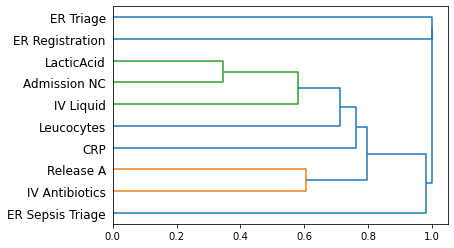

In [7]:
def generate_hierarchies_from_log():
    # Compute the pairwise distances of the created DFG from the event log
    # pairwise_distances = get_jaccard_distance_of_dfg(log)
    pairwise_distances = get_simrank_similarity_of_dfg(log)

    # saves the directly follows graph as an svg
    show_dfg_of_log(log)

    # Generate the distance matrix used for performing hierarchical clustering
    # activities, distances = convert_jaccard_distances_to_distance_matrix(log, pairwise_distances)
    activities, distances = convert_simrank_distances_to_distance_matrix(log, pairwise_distances)

    # Perform hierarchical clustering using scipy
    linkage_matrix = create_linkage(distances)

    # create a dictionary for every clustering performed at each step
    clusterings = create_clusterings_for_every_level(activities, distances, linkage_matrix)

    # create a dendrogram for illustrative purposes
    result_dendrogram = create_dendrogram(activities, linkage_matrix)

    # create the hierarchy needed for event log abstraction
    hierarchies = create_hierarchy_for_activities(activities, clusterings)
    # pprint.pprint(hierarchies)
